In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


from xcquinox.net import GGA_FcNet_s, GGA_FxNet_s
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:773: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [57]:
def nb_gen_grid_s(npts=30000, start_stop_rho = (0.01, 5), start_stop_s = (0.01, 5),
               train_pct = 0.8, ranseed=92017):
    '''
    Generates a grid of rho, grad_rho, and reduced_density_gradient values and returns their flattened forms to be fed into a given enhancement factor function for training or validation purposes.

    :param npts: Number of points to generate in each array, defaults to 30000. The function will get close, but not necessarily exactly the number of points, unless the desired value is a perfect square.
    :type npts: int, optional
    :param start_stop_rho: Bounds for the generated reduced_density_gradient values, defaults to (0.01, 5)
    :type start_stop_rho: tuple, optional
    :param start_stop_s: Bounds for the generated rho values, defaults to (0.01, 5)
    :type start_stop_s: tuple, optional
    :return: The flattened density, grad_rho, and s arrays
    :rtype: 3-tuple: (rho_flat, grad_rho_flat, s_flat)
    '''
    val_pct = 1.0 - train_pct
    START_RHO, STOP_RHO = start_stop_rho
    START_S, STOP_S = start_stop_s
    s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(npts)))
    s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(npts)))
    s_values = jnp.concatenate([s_values_low, s_values_high])
    rho_add = len(s_values) - int(jnp.sqrt(npts))
    rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(npts)+rho_add))
    k_F = (3 * jnp.pi**2 * rho_values)**(1/3)
    grad_rho_values = 2 * s_values * k_F * rho_values
    
    ind_sel = np.arange(0, len(s_values))
    np.random.seed(ranseed)
    val_inds = np.random.choice(ind_sel, size = int(val_pct*len(s_values)), replace=False)
    train_inds = np.array([i for i in ind_sel if i not in val_inds])
    #randomize training point order
    np.random.shuffle(train_inds)

    trho_values = rho_values[train_inds]
    vrho_values = rho_values[val_inds]
    
    ts_values = s_values[train_inds]
    vs_values = s_values[val_inds]

    trho_mesh, ts_mesh = jnp.meshgrid(trho_values, ts_values)
    trho_flat = trho_mesh.flatten()
    ts_flat = ts_mesh.flatten()
    # Calculate grad_rho
    tk_F = (3 * jnp.pi**2 * trho_flat)**(1/3)
    tgrad_rho_flat = 2 * ts_flat * tk_F * trho_flat

    vrho_mesh, vs_mesh = jnp.meshgrid(vrho_values, vs_values)
    vrho_flat = vrho_mesh.flatten()
    vs_flat = vs_mesh.flatten()
    # Calculate grad_rho
    vk_F = (3 * jnp.pi**2 * vrho_flat)**(1/3)
    vgrad_rho_flat = 2 * vs_flat * vk_F * vrho_flat

    print('shapes- r/gr/s: {}/{}/{}'.format(rho_values.shape, grad_rho_values.shape, s_values.shape))
    return [(train_inds, val_inds), (rho_values, grad_rho_values, s_values),
            (trho_flat, tgrad_rho_flat, ts_flat), (vrho_flat, vgrad_rho_flat, vs_flat)]


In [58]:
#network structure
pbe_fx = GGA_FxNet_s(depth=3, nodes=16, seed=92017)
pbe_fc = GGA_FcNet_s(depth=3, nodes=16, seed=92017)

In [74]:
#training and validation values
inds, vals, tflats, vflats = nb_gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
print(len(rv), len(trf), len(vrf))
print(rv.shape, trf.shape, vrf.shape)

shapes- r/gr/s: (315,)/(315,)/(315,)
315 64009 3844
(315,) (64009,) (3844,)


In [77]:
train_inds, val_inds

(array([ 66, 313, 221, 275,  14, 310, 180, 165,  27, 225, 179, 132,  58,
        161,  35, 284,  21, 119, 229,  93, 257,  92, 176, 301, 308, 163,
         60, 297, 167, 208, 236, 187, 147, 237, 261, 197,  54,  99, 302,
        171, 259, 246, 295, 233,   1, 129,  64,  67, 252, 224, 256, 130,
        207, 299, 160, 191,  98, 203,  73, 182, 181, 103, 292,  23,  34,
        234,  10,   9, 298, 212, 113,   7, 290,  25, 110, 131,  96, 186,
         40, 122, 291, 286, 100, 107,  95,  65,  75, 138, 140, 210,  36,
         89,  47, 250, 108, 312, 231, 139,  62,  15,  28, 296,  79,  59,
        133, 293, 185, 251, 314,  33, 240, 195,   8,  45, 204, 311, 175,
        274, 153,  91,  84,  85, 159, 137, 166, 276, 104, 192,  81,  49,
        193, 199, 222, 217, 190, 279, 105, 198, 121, 173, 143, 235, 155,
         12, 128, 305,  22,  38,  17,  26,  71,   6, 232, 282, 307,  82,
        244, 281, 215,  52,  87,  63, 188, 118, 219,  32, 243,  19, 184,
        280, 125,  74, 238, 169, 120, 111, 154, 177

In [75]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

sinputs = jnp.stack([trf, tsf], axis=1)
sval = jnp.stack([vrf, vsf], axis=1)
print(sval.shape, sinputs.shape)

(3844, 2) (64009, 2)


Text(0.5, 0, 's')

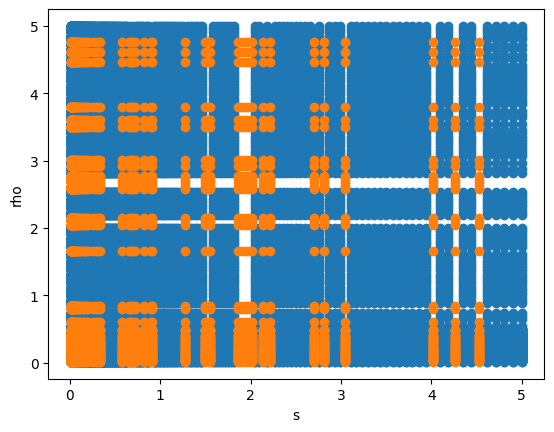

In [76]:
plt.scatter(trf, tsf)
plt.scatter(vrf, vsf)
plt.ylabel('rho')
plt.xlabel('s')

In [78]:
#create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-4)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

In [79]:
pt_pbe_fx = Pretrainer(model = pbe_fx, optim = optimizer_fx, inputs = sinputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
pt_pbe_fc = Pretrainer(model = pbe_fc, optim = optimizer_fc, inputs = sinputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [80]:
nmx, nlx = pt_pbe_fx()
nmc, nlc = pt_pbe_fc()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.09844872335327282
Epoch 200: Loss = 0.06325872688253248
Epoch 300: Loss = 0.022543970055829095
Epoch 400: Loss = 0.0035225629675758874
Epoch 500: Loss = 0.002974922958551258
Epoch 600: Loss = 0.0024582211538656203
Epoch 700: Loss = 0.0019585930070951394
Epoch 800: Loss = 0.0014636003892057594
Epoch 900: Loss = 0.0010763426445123403
Epoch 1000: Loss = 0.0008263259660462232
Epoch 1100: Loss = 0.000626140636807112
Epoch 1200: Loss = 0.00039735972843363656
Epoch 1300: Loss = 0.000302643497868761
Epoch 1400: Loss = 0.00026677924538162087
Epoch 1500: Loss = 0.00024065298366670603
Epoch 1600: Loss = 0.00021165557582128637
Epoch 1700: Loss = 0.00018650099396847573
Epoch 1800: Loss = 0.0001644083635662091
Epoch 1900: Loss = 0.0001454986512011504
Epoch 2000: Loss = 0.00012810420205962292
Epoch 2100: Loss = 0.00011246143438366865
Epoch 2200: Loss = 9.902745389103789e-05
Epoch 2300: Loss = 8.773345212590733e-05
Epoch 2400: Loss = 7.7296794904

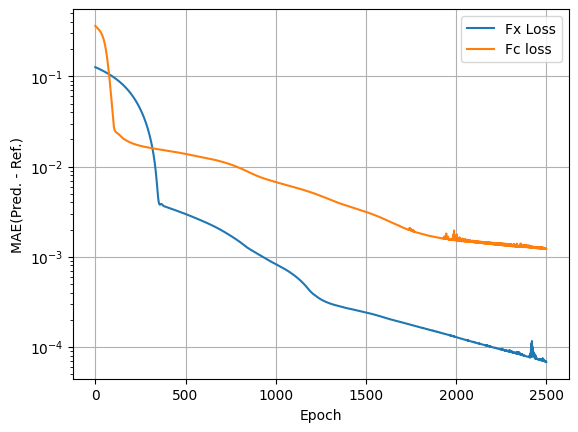

In [81]:
plt.plot(nlx, label='Fx Loss')
plt.plot(nlc, label='Fc loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MAE(Pred. - Ref.)')
plt.grid()
plt.legend()

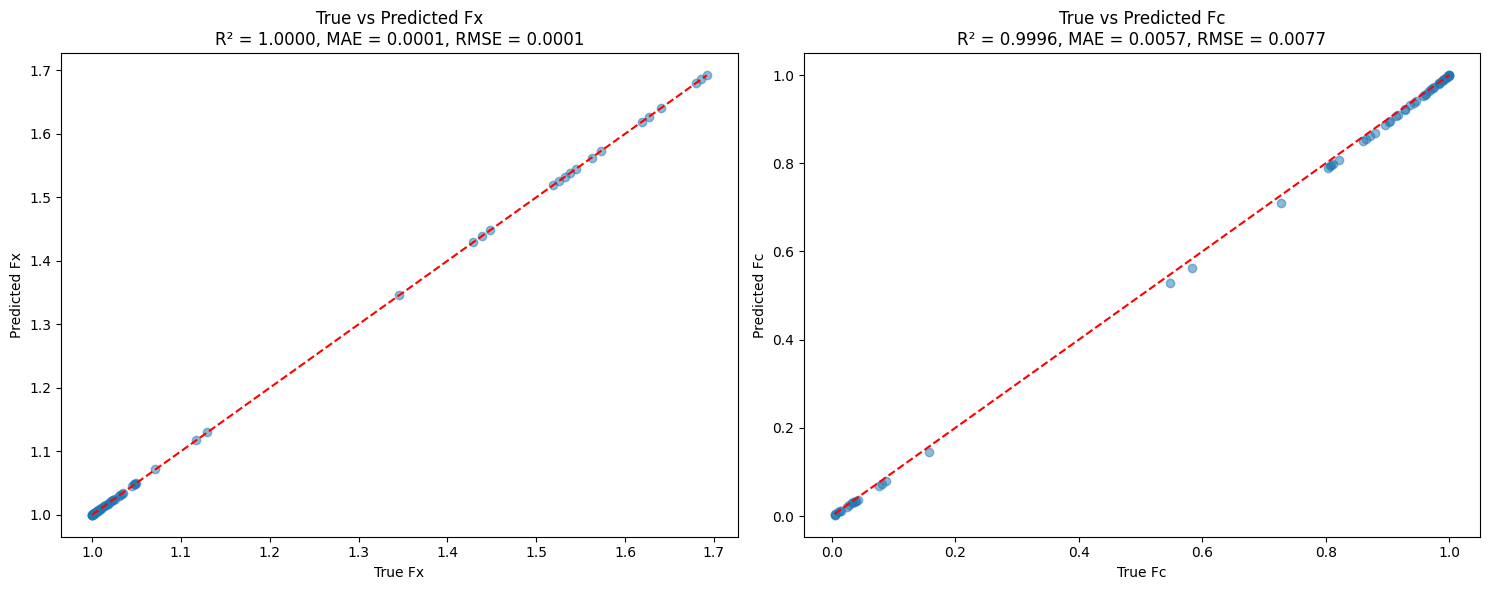

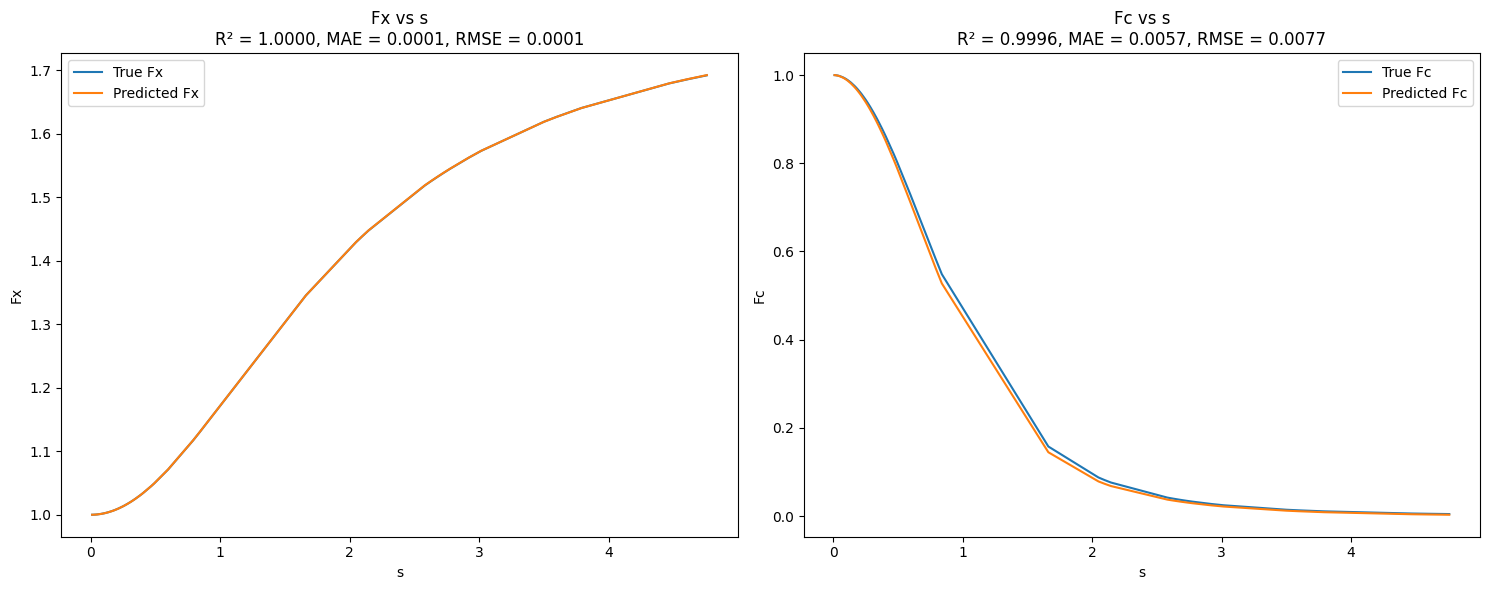

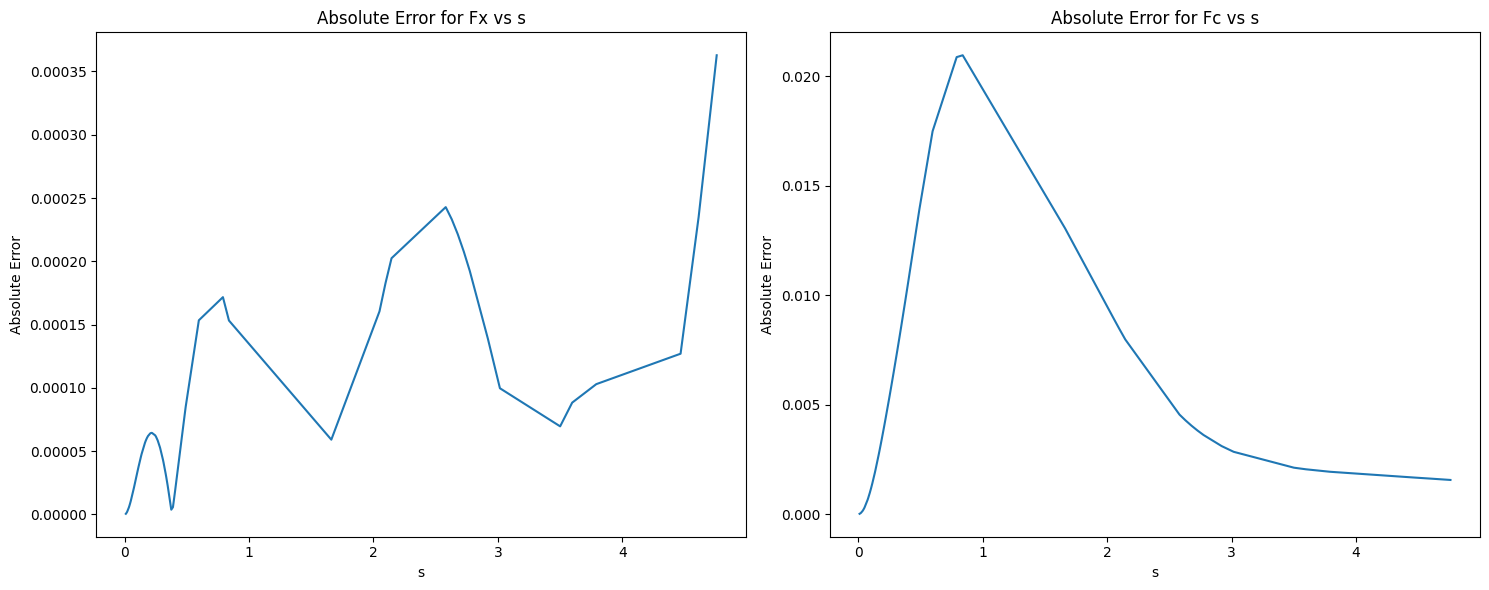

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000082
Root Mean Squared Error: 0.000111
Maximum Absolute Error: 0.000363

Fc Statistics:
R-squared: 0.999635
Mean Absolute Error: 0.005657
Root Mean Squared Error: 0.007655
Maximum Absolute Error: 0.020952


In [121]:
#for simplicity, we assume constant rho=1 for this test case and use the validation s; the 2d case will show the validation set using both
test_s = jnp.array(sorted(sv[val_inds]))
test_rho = jnp.full_like(test_s, rv[val_inds].min())
test_1d = jnp.stack([test_rho, test_s], axis=1)
# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Calculate true PBE enhancement factors
true_fx_test = PBE_Fx(test_rho, grad_rho_test)
true_fc_test = PBE_Fc(test_rho, grad_rho_test)

pred_fx = jax.vmap(nmx)(test_1d)
pred_fc = jax.vmap(nmc)(test_1d)

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)
# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

In [143]:
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()], interpolation='none')
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    # ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    # ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    # ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()


In [144]:
test_s = jnp.array(sorted(sv[val_inds]))
test_rho = jnp.array(sorted(rv[val_inds]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(nmx)(img_sinps)
pred_fc = jax.vmap(nmc)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000082
Root Mean Squared Error: 0.000111
Maximum Absolute Error: 0.000363

Fc Statistics:
R-squared: 0.999635
Mean Absolute Error: 0.005657
Root Mean Squared Error: 0.007655
Maximum Absolute Error: 0.020952


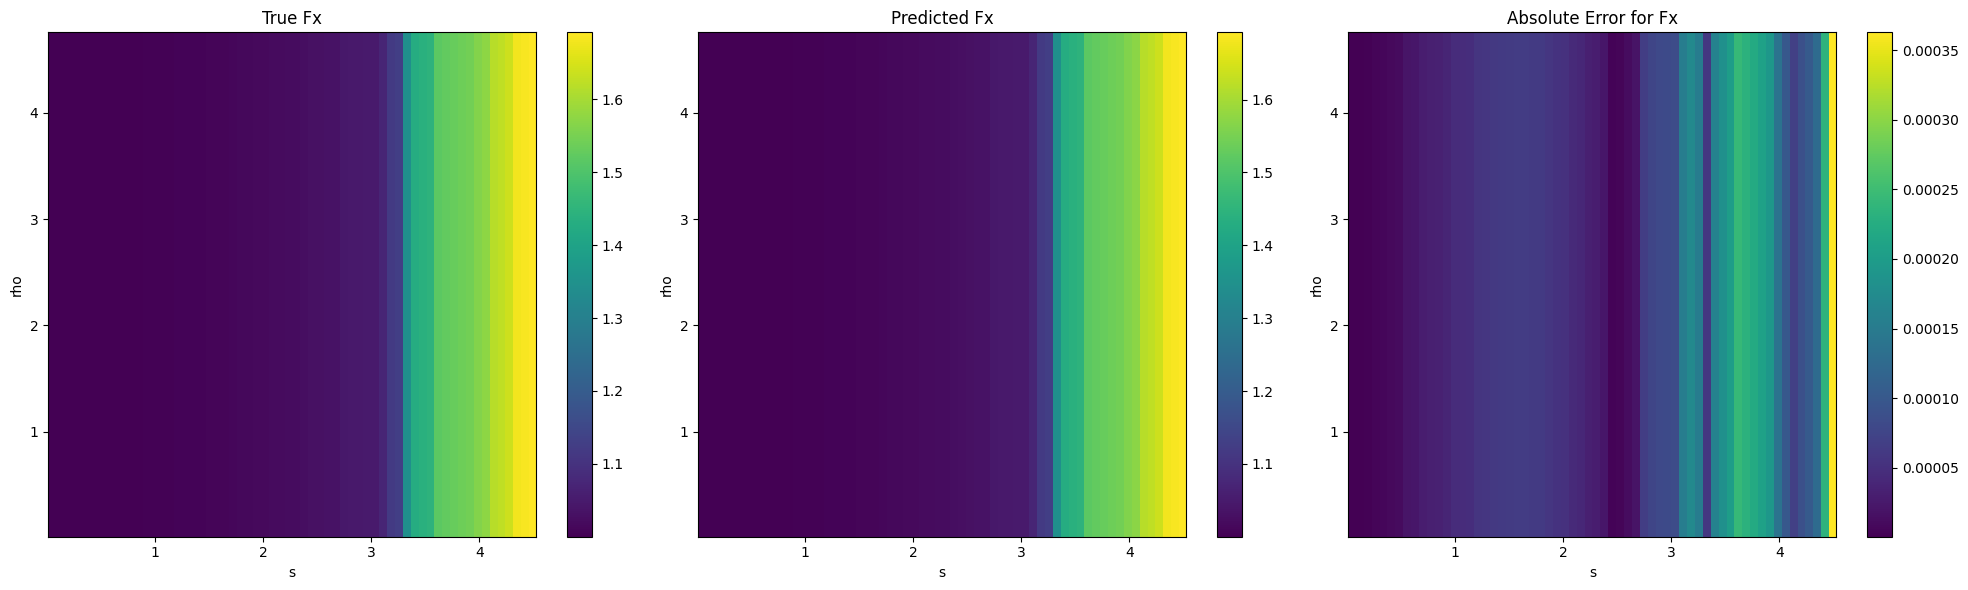

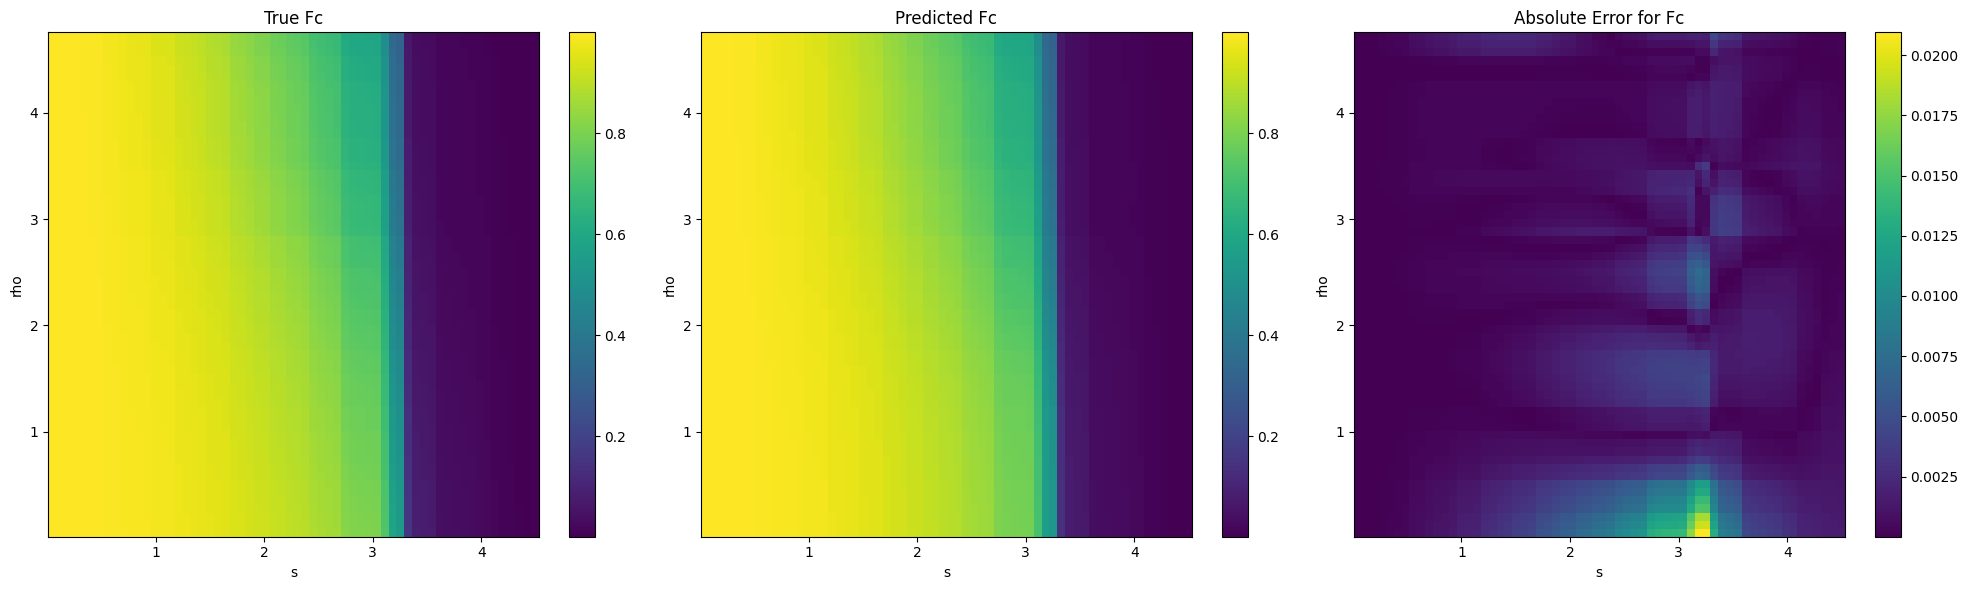

In [145]:
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)


Text(0, 0.5, 'rho')

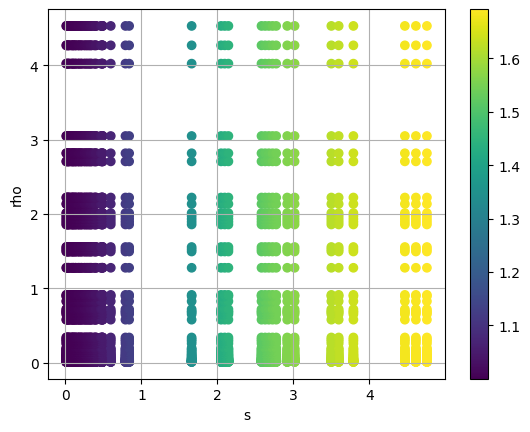

In [142]:
plt.scatter(s_mesh.flatten(), rho_mesh.flatten(), c=pred_fx)
plt.colorbar()
plt.grid()
plt.xlabel('s')
plt.ylabel('rho')

Text(0, 0.5, 'rho')

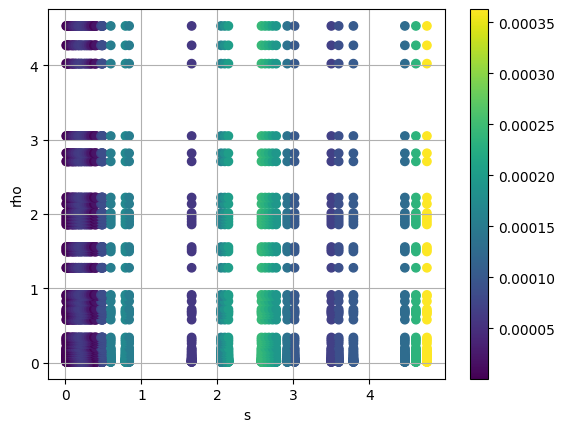

In [147]:
plt.scatter(s_mesh.flatten(), rho_mesh.flatten(), c=abs(true_fx_test- pred_fx))
plt.colorbar()
plt.grid()
plt.xlabel('s')
plt.ylabel('rho')

Text(0, 0.5, 'rho')

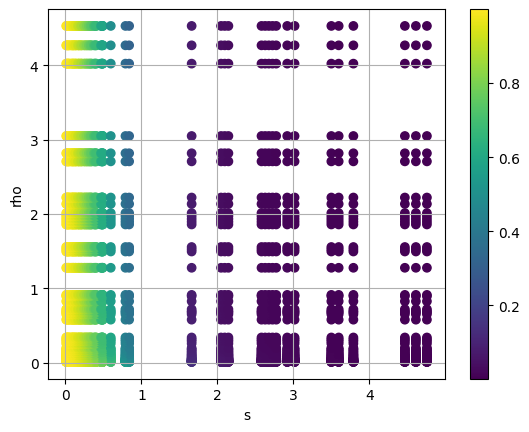

In [146]:
plt.scatter(s_mesh.flatten(), rho_mesh.flatten(), c=pred_fc)
plt.colorbar()
plt.grid()
plt.xlabel('s')
plt.ylabel('rho')

Text(0, 0.5, 'rho')

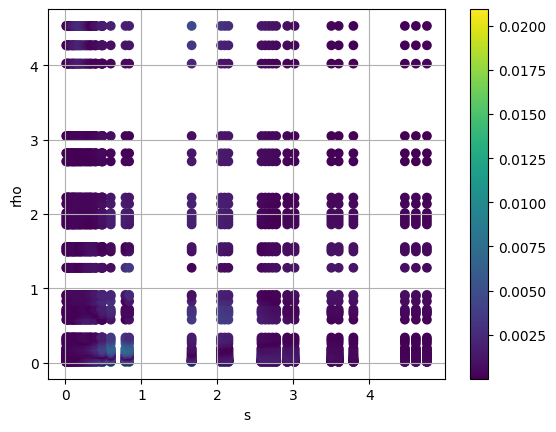

In [148]:
plt.scatter(s_mesh.flatten(), rho_mesh.flatten(), c=abs(true_fc_test- pred_fc))
plt.colorbar()
plt.grid()
plt.xlabel('s')
plt.ylabel('rho')